In [419]:
import urllib.request as url
import re
import html

In [420]:
from time import sleep

In [421]:
import json

#Get posts:

In [423]:
import urllib.request as url
import json
offset = 0
posts = []
while True:
    while offset < 200:
        req = url.Request('https://api.vk.com/method/wall.get?domain=weirdkerneltricks&count=100&offset=' + str(offset))
        response = url.urlopen(req)
        result = response.read().decode('utf-8')
        try:
            pst = json.loads(result)["response"]
        except KeyError:
            continue
        posts.extend(pst)
        offset += 100
    else:
        break
posts1 = posts[1:-1]
posts1
pd = []
f = open('posts.txt', 'w', encoding = 'utf-8')
f.close()
for p in posts1:
    try:
        post_id = p["id"]
    except:
        post_id = 0
    try:
        text = p["text"]
        text = html.unescape(text)
        text = re.sub('<br>', ' ', text)
        if text != '':
            text_len = len(text.split(' '))
        else:
            text_len = 0
    except:
        text = 0
    if text != 0:
        f = open('posts.txt', 'a', encoding='utf-8')
        f.write(text + "\n")
        f.close()
    try:
        signer_id = p["signer_id"]
    except:
        try:
            signer_id = p["from_id"]
        except:
            signer_id = 0
    try:
        count_com = p["comments"]["count"]
    except:
        count_com = 0
    post_data = {"post_id" : post_id, "signer_id" : signer_id, "length" : text_len, "count_com" : count_com}
    pd.append(post_data)

In [424]:
import os
def json_maker(comments, post_id, offset):
    gd = os.getcwd()
    if offset != 0:
        f = open(gd + '\FJ\data_' + str(post_id) + '.json', 'r', encoding='utf-8')
        s = f.read()
        f.close()
        k = json.loads(s) # k is a dictionary
        lng = k["length"]
        lng.extend(comments["length"])
        if len(lng) == 0:
            mean = 0
        else:
            mean = round((sum(lng))/len(lng))
        signer_id = k["signer_id"]
        signer_id.extend(comments["signer_id"])
        c = {"post_id" : k["post_id"], "mean" : mean, "length" : lng, "signer_id" : signer_id}
        f = open(gd + '\FJ\data_' + str(post_id) + '.json', 'w', encoding='utf-8')
        json.dump(c, f)
        f.close()
    else:
        f = open(gd + '\FJ\data_' + str(post_id) + '.json', 'w', encoding='utf-8')
        json.dump(comments, f) #comments are written in f
        f.close()

#Get comments:

In [425]:
offset = 0
comments = {}
dct ={}
i = 0
n = 0
x = 0
f = open('comments.txt', 'w', encoding = 'utf-8')
f.close()
while True:
    while offset < 200:
        for dic_p in pd:
            if dic_p["count_com"] == 0:
                comments = {"post_id" : dic_p["post_id"], "mean" : 0, "length" : [], "signer_id" : []}
                i += 1
                json_maker(comments, dic_p["post_id"], offset)
                n += 1
                comments.clear()
                continue
            else:
                req = url.Request('https://api.vk.com/method/wall.getComments?owner_id=-131489096&post_id='+\
                                  str(dic_p["post_id"])+'&count=100&offset=' + str(offset))
                response = url.urlopen(req)
                result = response.read().decode('utf-8')
                try:
                    cmt = json.loads(result)["response"]
                except:
                    comments = {"post_id" : dic_p["post_id"], "mean" : 0, "length" : [], "signer_id" : []}
                    i += 1
                    json_maker(comments, dic_p["post_id"], offset)
                    continue
                com_ids = []
                length = []
                signer_id = []
                for e in cmt[1:-1]:
                    try:
                        com_id = e["cid"]
                    except:
                        com_id = 0
                    com_ids.append(com_id)
                    try:
                        val = e["text"]
                        text = html.unescape(val)
                        text = re.sub('<br>', ' ', text)
                    except:
                        text = ''
                    if text != '':
                        text_len = len(text.split(' '))
                    else:
                        text_len = 0
                    try:
                        user_id = e["from_id"]
                    except:
                        user_id = 0
                    length.append(text_len)
                    signer_id.append(user_id)
                    f = open('comments.txt', 'a', encoding='utf-8')
                    f.write(text + "\n")
                    f.close()
                if len(com_ids) == 0:
                    mean_len = 0
                    x += 1
                else:
                    mean_len = round(sum(length)/len(com_ids))
                i += 1
                comments = {"post_id" : dic_p["post_id"], "mean" : mean_len, "length" : length, "signer_id" : signer_id}
                json_maker(comments, dic_p["post_id"], offset)
            comments.clear()
        offset += 100
    else:
        break

#Make correspondence graph between post length and its comments mean length

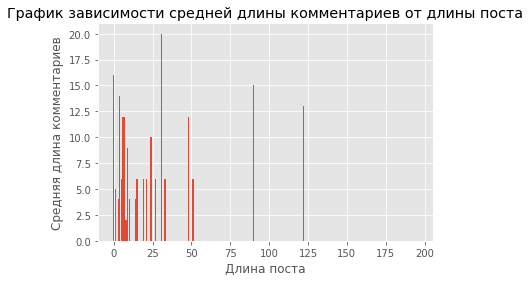

In [426]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

postlen = []
com_mean = []
for dc in pd: 
    f = open(gd + '\FJ\data_' + str(dc["post_id"]) + '.json', 'r', encoding='utf-8')
    s = f.read()
    f.close()
    g = json.loads(s)
    postlen.append(dc["length"])
    com_mean.append(g["mean"])
plt.bar(postlen, com_mean)
plt.title('График зависимости средней длины комментариев от длины поста')
plt.xlabel('Длина поста')
plt.ylabel('Средняя длина комментариев')
plt.savefig('lenpost_lencomment.pdf')
plt.show()
plt.close()

#Fill our files:

In [427]:
import json 
c ={}
users_inf = []
for dc in pd: 
    f = open(gd + '\FJ\data_' + str(dc["post_id"]) + '.json', 'r', encoding='utf-8')
    s = f.read()
    f.close()
    g = json.loads(s)
    uid = g["signer_id"] #array of users who wrote comments
    author_id = dc["signer_id"] #number
    
    if not str(author_id).startswith('-') and uid != []:
        req = url.Request('https://api.vk.com/method/users.get?user_ids=' + str(author_id) + '&fields=bdate,city')
        response = url.urlopen(req)
        result = response.read().decode('utf-8')
        auth = json.loads(result)["response"]
        try:
            city_auth = auth[0]["city_id"]
        except:
            city_auth = ''
        try:
            bdate_auth = auth[0]["bdate"]
        except:
            bdate_auth = 0
    else:
        city_auth = ''
        bdate_auth = 0
    c = {"author_id" : author_id, "city_authid" : city_auth, "bdate_auth" : bdate_auth}
    f = open(gd + '\FJ\data_' + str(dc["post_id"]) + '.json', 'w', encoding='utf-8')
    g.update(c)
    json.dump(g, f, ensure_ascii=False)
    f.close()
    
    cities = []
    bdates = []
    if uid != []:
        for i in uid:
            if not str(i).startswith('-'):
                req = url.Request('https://api.vk.com/method/users.get?user_ids=' + str(i) + '&fields=bdate,city')
                response = url.urlopen(req)
                result = response.read().decode('utf-8')
                try:
                    us = json.loads(result)["response"]
                except:
                    print(dc["post_id"])
                users_inf.extend(us)
                for el in users_inf:
                    try:
                        bdate = el["bdate"]
                    except:
                        bdate = 0
                    try:
                        city_id = el["city"]
                    except:
                        city_id = ''
            else:
                city_id = ''
                bdate   = 0
            cities.append(city_id)
            bdates.append(bdate)
    users_inf.clear()
    c = {"city_id" : cities, "bdate" : bdates}
    f = open(gd + '\FJ\data_' + str(dc["post_id"]) + '.json', 'w', encoding='utf-8')
    g.update(c)
    json.dump(g, f, ensure_ascii=False)
    f.close()

In [428]:
def ages(bdate):
    now_date = datetime.date.today()
    now_year = int(now_date.strftime("%Y"))
    ages = []
    for dat in bdate:
        if dat != 0:
            res = re.search('(.*?)\.(.*)(\.(.*))', dat)
            if res != None:
                year = int(res.group(4))
                age = now_year - year
                ages.append(age)
            else:
                ages.append(0)
        else:
            ages.append(0)
    return ages

In [429]:
import datetime
import time
g = {}
now_date = datetime.date.today()
now_date = now_date.strftime("%d.%m.%Y")
cities = []
for dc in pd: 
    f = open(gd + '\FJ\data_' + str(dc["post_id"]) + '.json', 'r', encoding='utf-8')
    s = f.read()
    f.close()
    g = json.loads(s)
    city_id = g["city_id"] #array
    city_authid = g["city_authid"] #number or ''
    bdate = g["bdate"] #array
    bdate_auth = [g["bdate_auth"]] #array with one element or 0
    age_auth = ages(bdate_auth)
    users_ages = ages(bdate)
    c = {"users_ages" : users_ages, "auth_age" : age_auth}
    f = open(gd + '\FJ\data_' + str(dc["post_id"]) + '.json', 'w', encoding='utf-8')
    g.update(c)
    json.dump(g, f, ensure_ascii=False)
    f.close()
    
    if city_authid != '':
        req = url.Request('https://api.vk.com/method/database.getCitiesById?city_ids=' + str(city_authid))
        response = url.urlopen(req)
        result = response.read().decode('utf-8')
        ct = json.loads(result)["response"]
        c = {"city_authname" : ct[0]}
    else:
        c = {"city_authname" : '?'}
    f = open(gd + '\FJ\data_' + str(dc["post_id"]) + '.json', 'w', encoding='utf-8')
    g.update(c)
    json.dump(g, f, ensure_ascii=False)
    f.close()
    
    for ci in city_id:
        if ci != '':
            req = url.Request('https://api.vk.com/method/database.getCitiesById?city_ids=' + str(ci))
            response = url.urlopen(req)
            result = response.read().decode('utf-8')
            ct = json.loads(result)["response"]
            if ct != []:
                for e in ct:
                    c_name = ct[0]["name"]
                    cities.append(c_name)
            else:
                cities.append('?')
        else:
            cities.append('?')
    c = {"city_name" : cities}
    f = open(gd + '\FJ\data_' + str(dc["post_id"]) + '.json', 'w', encoding='utf-8')
    g.update(c)
    json.dump(g, f, ensure_ascii=False)
    f.close()
    cities.clear()

#График зависимости длины коммента/поста от возраста

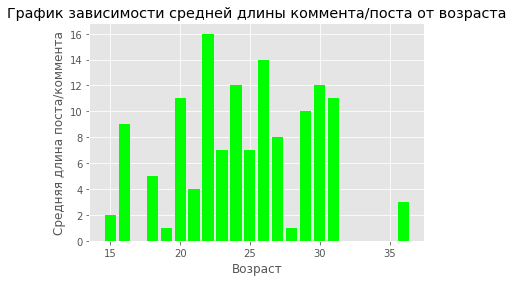

In [430]:
g = {}
lng = []
ag = []
for dc in pd:
    f = open(gd + '\FJ\data_' + str(dc["post_id"]) + '.json', 'r', encoding='utf-8')
    s = f.read()
    f.close()
    g = json.loads(s)
    len_post = dc["length"] # number
    length = g["length"] #array of comments lengths
    auth_age = g["auth_age"] #array with one element which can be a number or a '?'
    users_ages = g["users_ages"] #array of numbers. '?' appear
    length.append(len_post)
    lng.extend(length)
    users_ages.extend(auth_age)
    ag.extend(users_ages)
i = 0
t = []  #ages - users then authors
ln = []  #ln - length comments then posts
u = []   #счетчик
for el in ag:
    if el == 0:
        i += 1
        continue
    if el not in t:
        u.append(1)
        t.append(el)
        ln.append(lng[i])
    else:
        k = t.index(el)
        u[k] += 1
        ln[k] += lng[i]
    i+=1
i = 0
mean_len = []
for x in ln:
    m = round(x/u[i])
    mean_len.append(m)
    i += 1
plt.bar(t, mean_len, color='lime')
plt.title("График зависимости средней длины коммента/поста от возраста")
plt.xlabel("Возраст")
plt.ylabel("Средняя длина поста/коммента")
plt.savefig('len_age.pdf')
plt.show()
plt.close()

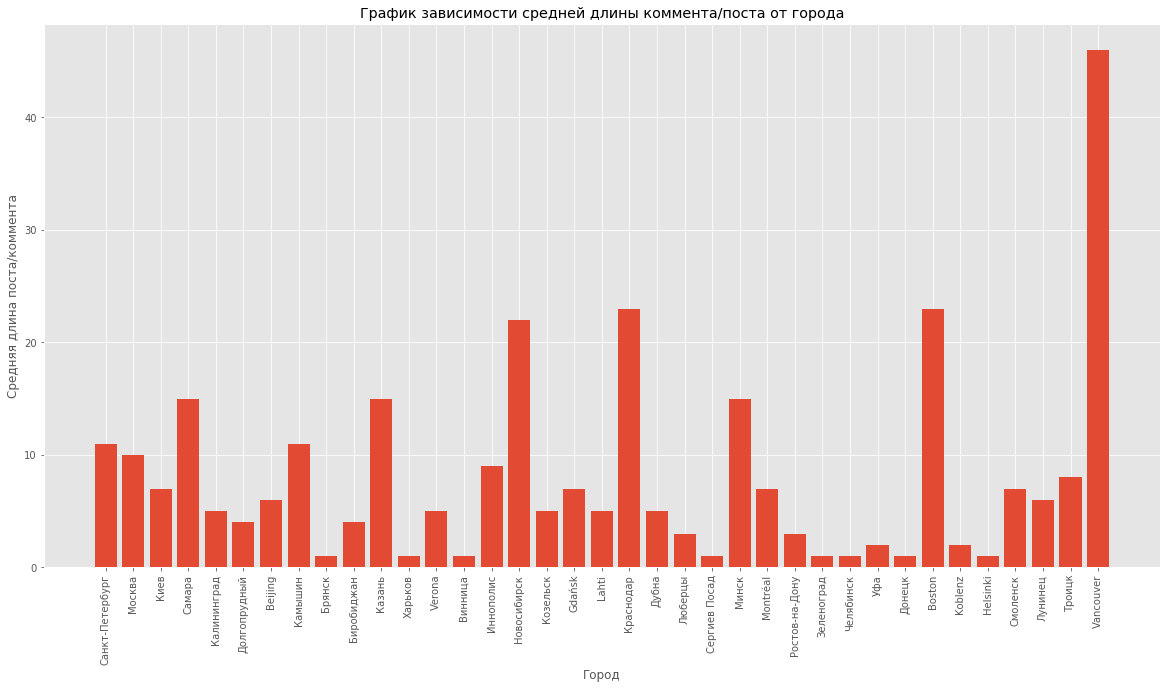

In [412]:
g = {}
c_names = []
for dc in pd:
    f = open(gd + '\FJ\data_' + str(dc["post_id"]) + '.json', 'r', encoding='utf-8')
    s = f.read()
    f.close()
    g = json.loads(s)
    city_authname = [g["city_authname"]]
    city_name = g["city_name"]
    city_name.extend(city_authname)
    c_names.extend(city_name)
l = [] #длины
u = [] #счётчик
cities = []
j = 0
for el in c_names:
    if el == "?":
        j += 1
        continue
    if el not in cities:
        cities.append(el)
        l.append(lng[j])
        u.append(1)
    else:
        k = cities.index(el)
        u[k] += 1
        l[k] += lng[j]
    j += 1
i = 0
mean_len = []
for x in l:
    m = round(x/u[i])
    mean_len.append(m)
    i += 1
plt.figure(figsize=(20,10))
plt.bar(range(len(mean_len)), mean_len) #color='cyan')
plt.xticks(range(len(mean_len)), cities, rotation='vertical')
plt.title("График зависимости средней длины коммента/поста от города")
plt.xlabel("Город")
plt.ylabel("Средняя длина поста/коммента")
plt.savefig('len_city.png')
plt.show()
plt.close()